In [1]:
!pip install -q "monai[nibabel]" --no-deps
!pip install -q protobuf==3.20.*
!pip install -q scikit-learn
!pip install -q medpy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 5.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
onnx 1.18.0 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
a2a-sdk 0.3.10 requires protobuf>=5.29.5, but you have protobuf 3.20.3 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
tensorflow-metadata 1.17.2 requires protobuf>=4.25.2; python_version >= "3.11", but you have protob

In [2]:
import os, random, numpy as np
import torch, torch.nn as nn
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import pandas as pd

import monai
from monai.transforms import *
from monai.data import Dataset
from monai.networks.nets import SwinUNETR
from monai.losses import DiceCELoss, FocalLoss, TverskyLoss
from monai.inferers import sliding_window_inference

from sklearn.model_selection import KFold

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
print("MONAI:", monai.__version__)


<frozen importlib._bootstrap_external>:1241: FutureWarning: The cuda.cudart module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.runtime module instead.
2025-12-15 06:36:01.773475: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765780561.928439      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765780561.976861      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Device: cuda
MONAI: 1.5.1


In [3]:
BASE = "/kaggle/input/brats20-dataset-training-validation"
TRAIN_ROOT = f"{BASE}/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
VAL_ROOT   = f"{BASE}/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData"

IMG_SIZE = (96, 96, 96)
IN_CHANNELS = 4
OUT_CHANNELS = 4

NUM_FOLDS = 5
EPOCHS = 12
BATCH_SIZE = 1
LR = 1e-4
WEIGHT_DECAY = 1e-5
FEATURE_SIZE = 48


In [4]:
def load_brats_train(root):
    items = []
    for case in sorted(os.listdir(root)):
        folder = os.path.join(root, case)
        if not os.path.isdir(folder):
            continue

        required = ["flair", "t1", "t1ce", "t2", "seg"]
        files = os.listdir(folder)

        if not all(any(r in f for f in files) for r in required):
            continue

        items.append({
            "id": case,
            "flair": f"{folder}/{case}_flair.nii",
            "t1":    f"{folder}/{case}_t1.nii",
            "t1ce":  f"{folder}/{case}_t1ce.nii",
            "t2":    f"{folder}/{case}_t2.nii",
            "seg":   f"{folder}/{case}_seg.nii",
        })
    return items

train_cases = load_brats_train(TRAIN_ROOT)
print("✅ Valid training cases:", len(train_cases))


✅ Valid training cases: 368


In [5]:
train_transforms = Compose([
    LoadImaged(keys=["flair","t1","t1ce","t2","seg"]),
    EnsureChannelFirstd(keys=["flair","t1","t1ce","t2","seg"]),
    Orientationd(keys=["flair","t1","t1ce","t2","seg"], axcodes="RAS"),
    Spacingd(
        keys=["flair","t1","t1ce","t2","seg"],
        pixdim=(1,1,1),
        mode=("bilinear","bilinear","bilinear","bilinear","nearest")
    ),
    CropForegroundd(keys=["flair","t1","t1ce","t2","seg"], source_key="flair"),
    ResizeWithPadOrCropd(
        keys=["flair","t1","t1ce","t2","seg"],
        spatial_size=IMG_SIZE
    ),
    NormalizeIntensityd(
        keys=["flair","t1","t1ce","t2"],
        nonzero=True,
        channel_wise=True
    ),
    # Remap label 4 → 3
    LambdaD(keys="seg", func=lambda x: (x == 4).astype(x.dtype)*3 + (x != 4)*x),
    ConcatItemsd(keys=["flair","t1","t1ce","t2"], name="image"),
    EnsureTyped(keys=["image","seg"])
])


/usr/local/lib/python3.11/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.spatial.dictionary Orientationd.__init__:labels: Current default value of argument `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` was changed in version None from `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` to `labels=None`. Default value changed to None meaning that the transform now uses the 'space' of a meta-tensor, if applicable, to determine appropriate axis labels.
  warn_deprecated(argname, msg, warning_category)


In [6]:
dice_ce = DiceCELoss(include_background=False, to_onehot_y=True, softmax=True)
focal   = FocalLoss(include_background=False, to_onehot_y=True, gamma=2.0)
tversky = TverskyLoss(
    include_background=False,
    to_onehot_y=True,
    softmax=True,
    alpha=0.3,
    beta=0.7
)

def hybrid_loss(pred, target):
    return 0.4*dice_ce(pred, target) + \
           0.3*focal(pred, target) + \
           0.3*tversky(pred, target)


In [7]:
def dice_region(pred, gt):
    eps = 1e-8

    # WT: 1,2,3
    wt = (2*np.sum((pred>0)&(gt>0))) / (
        np.sum(pred>0) + np.sum(gt>0) + eps
    )

    # TC: 1,3
    tc = (2*np.sum(((pred==1)|(pred==3)) &
                   ((gt==1)|(gt==3)))) / (
        np.sum((pred==1)|(pred==3)) +
        np.sum((gt==1)|(gt==3)) + eps
    )

    # ET: 3
    et = (2*np.sum((pred==3)&(gt==3))) / (
        np.sum(pred==3) + np.sum(gt==3) + eps
    )

    return wt, tc, et


In [8]:
kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)

history = []

for fold, (train_idx, val_idx) in enumerate(kf.split(train_cases)):
    print(f"\n🚀 Fold {fold+1}/{NUM_FOLDS}")

    train_ds = Dataset([train_cases[i] for i in train_idx], train_transforms)
    val_ds   = Dataset([train_cases[i] for i in val_idx], train_transforms)

    train_loader = DataLoader(train_ds, batch_size=1, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=1, shuffle=False)

    model = SwinUNETR(
        in_channels=IN_CHANNELS,
        out_channels=OUT_CHANNELS,
        feature_size=FEATURE_SIZE,
        use_checkpoint=True
    ).to(device)

    optimizer = torch.optim.AdamW(
        model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY
    )

    # ---------- TRAIN ----------
    for epoch in range(1, EPOCHS+1):
        model.train()
        pbar = tqdm(train_loader, desc=f"Fold {fold+1} | Epoch {epoch}/{EPOCHS}")
        for batch in pbar:
            img = batch["image"].to(device)
            seg = batch["seg"].to(device)

            optimizer.zero_grad()
            out = model(img)
            loss = hybrid_loss(out, seg)
            loss.backward()
            optimizer.step()

            pbar.set_postfix(loss=f"{loss.item():.4f}")

    # ---------- VALIDATION ----------
    model.eval()
    wt_l, tc_l, et_l = [], [], []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Fold {fold+1} Validation"):
            img = batch["image"].to(device)
            gt  = batch["seg"].cpu().numpy()[0,0]

            out = sliding_window_inference(img, IMG_SIZE, 1, model)
            pred = torch.argmax(out.softmax(1), 1).cpu().numpy()[0]

            wt, tc, et = dice_region(pred, gt)
            wt_l.append(wt)
            tc_l.append(tc)
            et_l.append(et)

    mean_dice = np.mean([np.mean(wt_l), np.mean(tc_l), np.mean(et_l)])
    history.append([fold+1, np.mean(wt_l), np.mean(tc_l), np.mean(et_l), mean_dice])

    print(f"🎯 Fold {fold+1} → WT:{np.mean(wt_l):.4f} TC:{np.mean(tc_l):.4f} ET:{np.mean(et_l):.4f} Mean:{mean_dice:.4f}")



🚀 Fold 1/5


Fold 1 | Epoch 1/12:   0%|          | 0/294 [00:00<?, ?it/s]

Fold 1 | Epoch 2/12:   0%|          | 0/294 [00:00<?, ?it/s]

Fold 1 | Epoch 3/12:   0%|          | 0/294 [00:00<?, ?it/s]

Fold 1 | Epoch 4/12:   0%|          | 0/294 [00:00<?, ?it/s]

Fold 1 | Epoch 5/12:   0%|          | 0/294 [00:00<?, ?it/s]

Fold 1 | Epoch 6/12:   0%|          | 0/294 [00:00<?, ?it/s]

Fold 1 | Epoch 7/12:   0%|          | 0/294 [00:00<?, ?it/s]

Fold 1 | Epoch 8/12:   0%|          | 0/294 [00:00<?, ?it/s]

Fold 1 | Epoch 9/12:   0%|          | 0/294 [00:00<?, ?it/s]

Fold 1 | Epoch 10/12:   0%|          | 0/294 [00:00<?, ?it/s]

Fold 1 | Epoch 11/12:   0%|          | 0/294 [00:00<?, ?it/s]

Fold 1 | Epoch 12/12:   0%|          | 0/294 [00:00<?, ?it/s]

Fold 1 Validation:   0%|          | 0/74 [00:00<?, ?it/s]

🎯 Fold 1 → WT:0.9049 TC:0.8066 ET:0.6984 Mean:0.8033

🚀 Fold 2/5


Fold 2 | Epoch 1/12:   0%|          | 0/294 [00:00<?, ?it/s]

Fold 2 | Epoch 2/12:   0%|          | 0/294 [00:00<?, ?it/s]

Fold 2 | Epoch 3/12:   0%|          | 0/294 [00:00<?, ?it/s]

Fold 2 | Epoch 4/12:   0%|          | 0/294 [00:00<?, ?it/s]

Fold 2 | Epoch 5/12:   0%|          | 0/294 [00:00<?, ?it/s]

Fold 2 | Epoch 6/12:   0%|          | 0/294 [00:00<?, ?it/s]

Fold 2 | Epoch 7/12:   0%|          | 0/294 [00:00<?, ?it/s]

Fold 2 | Epoch 8/12:   0%|          | 0/294 [00:00<?, ?it/s]

Fold 2 | Epoch 9/12:   0%|          | 0/294 [00:00<?, ?it/s]

Fold 2 | Epoch 10/12:   0%|          | 0/294 [00:00<?, ?it/s]

Fold 2 | Epoch 11/12:   0%|          | 0/294 [00:00<?, ?it/s]

Fold 2 | Epoch 12/12:   0%|          | 0/294 [00:00<?, ?it/s]

Fold 2 Validation:   0%|          | 0/74 [00:00<?, ?it/s]

🎯 Fold 2 → WT:0.8949 TC:0.7694 ET:0.7227 Mean:0.7957

🚀 Fold 3/5


Fold 3 | Epoch 1/12:   0%|          | 0/294 [00:00<?, ?it/s]

Fold 3 | Epoch 2/12:   0%|          | 0/294 [00:00<?, ?it/s]

Fold 3 | Epoch 3/12:   0%|          | 0/294 [00:00<?, ?it/s]

Fold 3 | Epoch 4/12:   0%|          | 0/294 [00:00<?, ?it/s]

Fold 3 | Epoch 5/12:   0%|          | 0/294 [00:00<?, ?it/s]

Fold 3 | Epoch 6/12:   0%|          | 0/294 [00:00<?, ?it/s]

Fold 3 | Epoch 7/12:   0%|          | 0/294 [00:00<?, ?it/s]

Fold 3 | Epoch 8/12:   0%|          | 0/294 [00:00<?, ?it/s]

Fold 3 | Epoch 9/12:   0%|          | 0/294 [00:00<?, ?it/s]

Fold 3 | Epoch 10/12:   0%|          | 0/294 [00:00<?, ?it/s]

Fold 3 | Epoch 11/12:   0%|          | 0/294 [00:00<?, ?it/s]

Fold 3 | Epoch 12/12:   0%|          | 0/294 [00:00<?, ?it/s]

Fold 3 Validation:   0%|          | 0/74 [00:00<?, ?it/s]

🎯 Fold 3 → WT:0.8978 TC:0.7696 ET:0.6499 Mean:0.7724

🚀 Fold 4/5


Fold 4 | Epoch 1/12:   0%|          | 0/295 [00:00<?, ?it/s]

Fold 4 | Epoch 2/12:   0%|          | 0/295 [00:00<?, ?it/s]

Fold 4 | Epoch 3/12:   0%|          | 0/295 [00:00<?, ?it/s]

Fold 4 | Epoch 4/12:   0%|          | 0/295 [00:00<?, ?it/s]

Fold 4 | Epoch 5/12:   0%|          | 0/295 [00:00<?, ?it/s]

Fold 4 | Epoch 6/12:   0%|          | 0/295 [00:00<?, ?it/s]

Fold 4 | Epoch 7/12:   0%|          | 0/295 [00:00<?, ?it/s]

Fold 4 | Epoch 8/12:   0%|          | 0/295 [00:00<?, ?it/s]

Fold 4 | Epoch 9/12:   0%|          | 0/295 [00:00<?, ?it/s]

Fold 4 | Epoch 10/12:   0%|          | 0/295 [00:00<?, ?it/s]

Fold 4 | Epoch 11/12:   0%|          | 0/295 [00:00<?, ?it/s]

Fold 4 | Epoch 12/12:   0%|          | 0/295 [00:00<?, ?it/s]

Fold 4 Validation:   0%|          | 0/73 [00:00<?, ?it/s]

🎯 Fold 4 → WT:0.9020 TC:0.7844 ET:0.7369 Mean:0.8078

🚀 Fold 5/5


Fold 5 | Epoch 1/12:   0%|          | 0/295 [00:00<?, ?it/s]

Fold 5 | Epoch 2/12:   0%|          | 0/295 [00:00<?, ?it/s]

Fold 5 | Epoch 3/12:   0%|          | 0/295 [00:00<?, ?it/s]

Fold 5 | Epoch 4/12:   0%|          | 0/295 [00:00<?, ?it/s]

Fold 5 | Epoch 5/12:   0%|          | 0/295 [00:00<?, ?it/s]

Fold 5 | Epoch 6/12:   0%|          | 0/295 [00:00<?, ?it/s]

Fold 5 | Epoch 7/12:   0%|          | 0/295 [00:00<?, ?it/s]

Fold 5 | Epoch 8/12:   0%|          | 0/295 [00:00<?, ?it/s]

Fold 5 | Epoch 9/12:   0%|          | 0/295 [00:00<?, ?it/s]

Fold 5 | Epoch 10/12:   0%|          | 0/295 [00:00<?, ?it/s]

Fold 5 | Epoch 11/12:   0%|          | 0/295 [00:00<?, ?it/s]

Fold 5 | Epoch 12/12:   0%|          | 0/295 [00:00<?, ?it/s]

Fold 5 Validation:   0%|          | 0/73 [00:00<?, ?it/s]

🎯 Fold 5 → WT:0.9032 TC:0.8541 ET:0.7787 Mean:0.8453


,Fold,WT,TC,ET,Mean
0,1,0.904912,0.806624,0.698367,0.803301
1,2,0.894869,0.769364,0.722724,0.795652
2,3,0.897831,0.769572,0.649921,0.772441
3,4,0.902019,0.784408,0.736871,0.807766
4,5,0.903170,0.854051,0.778695,0.845305


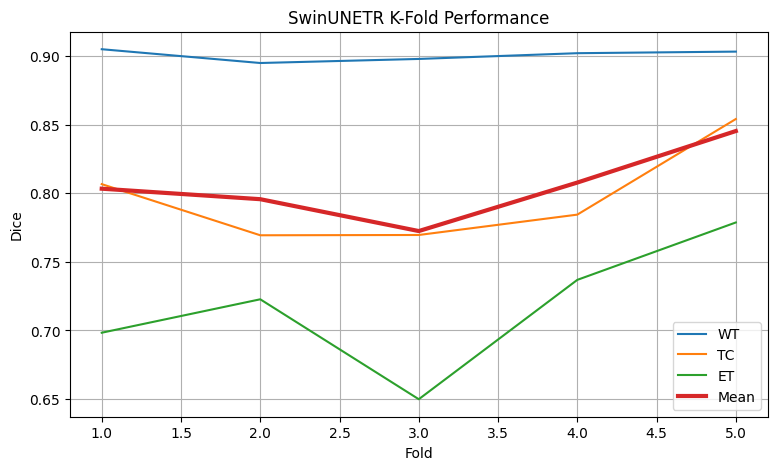

In [9]:
df = pd.DataFrame(history, columns=["Fold","WT","TC","ET","Mean"])
display(df)

plt.figure(figsize=(9,5))
plt.plot(df["Fold"], df["WT"], label="WT")
plt.plot(df["Fold"], df["TC"], label="TC")
plt.plot(df["Fold"], df["ET"], label="ET")
plt.plot(df["Fold"], df["Mean"], label="Mean", linewidth=3)
plt.xlabel("Fold")
plt.ylabel("Dice")
plt.title("SwinUNETR K-Fold Performance")
plt.legend()
plt.grid()
plt.show()
